In [1]:
from transformers import AutoTokenizer
from petals import AutoDistributedModelForCausalLM
import transformers
import torch
import utils

torch.cuda.empty_cache()

In [2]:
model = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model)
#tokenizer.pad_token_id = tokenizer.eos_token_id
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

Oct 18 16:51:50.243 [INFO] We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
def prompt_llama2(prompt):
    prompt_template=f'''[INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    <</SYS>> {prompt} [/INST]'''
    
    sequences = pipeline(
        prompt_template,
        do_sample=True,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        #max_length=2048,
        temperature=0.7,
        top_p=0.95,
        top_k=40,
        repetition_penalty=1.1,
    )
    result = sequences[0]['generated_text']
    return result.split('[/INST]')[1].strip()

def count_tokens(prompt):
    tokens = tokenizer.tokenize(prompt)
    return len(tokens)

def shorten_tokens(prompt):
    tokens = tokenizer.tokenize(prompt)
    tokens = tokens[:4000]
    return tokenizer.convert_tokens_to_string(tokens)

#### Get paragraphs for testing

In [11]:
urls = ['https://cs.illinois.edu/research/areas/artificial-intelligence',
        'https://cs.illinois.edu/research/undergraduate-research',
        'https://cs.illinois.edu/corporate#research']
from trafilatura import fetch_url, extract
paragraphs_dict = {}
for i in range(len(urls)):
    #p = utils.extract_paragraphs(urls[i])
    #p = utils.extract_paragraphs_trafilatura(urls[i])
    p = extract(fetch_url(urls[i]), favor_precision=True)
    paragraphs_dict[i] = p

### Try specific prompts

In [12]:
prompt = ''
for i in range(len(urls)):
    s = ''.join(paragraphs_dict[i]).replace('  ', ' ')
    prompt += f'Here is passage number {i+1}: "{s}"\n\n'
prompt += """
Can you combine these passages into a summary? First, display the summary in paragraph form.
Then, display the summary as a numbered list of sentences, and tell me the original passage that each numbered sentence came from.
"""
print(prompt)

Here is passage number 1: "Artificial Intelligence
The study of systems that behave intelligently, artificial intelligence includes several key areas where our faculty are recognized leaders: computer vision, machine listening, natural language processing, machine learning and robotics.
Computer vision systems can understand images and video, for example, building extensive geometric and physical models of cities from video, or warning construction workers about nearby dangers. Natural language processing systems understand written and spoken language; possibilities include automatic translation of text from one language to another, or understanding text on Wikipedia to produce knowledge about the world. Machine listening systems understand audio signals, with applications like speech recognition, acoustic monitoring, or transcribing polyphonic music automatically. Crucial to modern artificial intelligence, machine learning methods exploit examples in order to adjust systems to work as

In [12]:
out = prompt_llama2(prompt)
print(out)

Sure! Here is a summary of the three passages:

The University of Illinois has a highly regarded computer science program with world-renowned research in artificial intelligence, machine learning, natural language processing, computer vision, and robotics. Undergraduate students play an important role in this research and have opportunities to contribute early in their careers. The university has a large computer science department with a broad faculty base and a top-tier student body, offering students hands-on education and preparing them for leadership positions in academia and industry. Companies can recruit from the university through various means, including posting job openings on the online job board Handshake and partnering with the Corporate Connection affiliates program.

Here is the same summary in a numbered list of sentences, along with the original passage that each sentence came from:

1. The University of Illinois has a highly regarded computer science program with wor

In [21]:
prompt = ''
for i in range(len(urls)):
    s = ''.join(paragraphs_dict[i]).replace('  ', ' ')
    prompt += f'Here is passage number {i+1}: "{s}"\n\n'
prompt += """
Can you combine these passages into one short summary?
Before the end of each sentence in the summary, add a citation showing the original passage that the sentence came from.
For example, add "[Passage 1]" before the ending period of the sentence if the sentence came from the original Passage 1.
"""
print(prompt)

Here is passage number 1: "The study of systems that behave intelligently, artificial intelligence includes several key areas where our faculty are recognized leaders: computer vision, machine listening, natural language processing, machine learning and robotics.Computer vision systems can understand images and video, for example, building extensive geometric and physical models of cities from video, or warning construction workers about nearby dangers. Natural language processing systems understand written and spoken language; possibilities include automatic translation of text from one language to another, or understanding text on Wikipedia to produce knowledge about the world. Machine listening systems understand audio signals, with applications like speech recognition, acoustic monitoring, or transcribing polyphonic music automatically. Crucial to modern artificial intelligence, machine learning methods exploit examples in order to adjust systems to work as effectively as possible.

In [22]:
out = prompt_llama2(prompt)
print(out)

Of course! I would be happy to assist you. Here is the combined summary with citations:

The University of Illinois has a world-renowned computer science department that offers various research opportunities for undergraduate students [Passage 2]. Additionally, the university boasts one of the largest computer science departments in the nation, providing students with a broad range of academic and research experiences [Passage 3]. The department has a strong reputation for revolutionary technology and groundbreaking research, addressing real-world problems in various fields, including medicine, engineering, business, and science [Passage 3].

The computer science department offers various research collaborations and recruitment opportunities for companies, including the Corporate Connection program, which provides a main point of entry for partnering with the department [Passage 3]. Companies can also sponsor senior design projects, which give company representatives the opportunity to

### Clustering with K-Means

In [62]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [63]:
paragraphs = []
paragraphs_tag = []
for i in range(len(urls)):
    arr = paragraphs_dict[i]
    paragraphs.extend(arr)
    arr = [f'{i+1}:' + s for s in arr]
    paragraphs_tag.extend(arr)
paragraphs

['The study of systems that behave intelligently, artificial intelligence includes several key areas where our faculty are recognized leaders: computer vision, machine listening, natural language processing, machine learning and robotics.',
 'Computer vision systems can understand images and video, for example, building extensive geometric and physical models of cities from video, or warning construction workers about nearby dangers. Natural language processing systems understand written and spoken language; possibilities include automatic translation of text from one language to another, or understanding text on Wikipedia to produce knowledge about the world. Machine listening systems understand audio signals, with applications like speech recognition, acoustic monitoring, or transcribing polyphonic music automatically. Crucial to modern artificial intelligence, machine learning methods exploit examples in order to adjust systems to work as effectively as possible. Robotics puts artif

In [64]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(paragraphs)

In [65]:
k = 3
kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
kmeans.fit(tfidf_matrix)

KMeans(n_clusters=3, n_init=5, random_state=42)

In [66]:
silhouette_avg = silhouette_score(tfidf_matrix, kmeans.labels_)
silhouette_avg

0.03879463564652888

In [67]:
clusters = {1:[], 2:[], 3:[]}
for cluster_num in range(k):
    print(f"Cluster {cluster_num + 1}:")
    cluster_paragraphs = [paragraphs_tag[i] for i in range(len(paragraphs)) if kmeans.labels_[i] == cluster_num]
    for paragraph in cluster_paragraphs:
        clusters[cluster_num + 1] = paragraph
        print(paragraph)
    print()

Cluster 1:
3:The SRP will take place from
May 30-August 4, 2023.
3:The SRP will take place in a hybrid format with both in-person and online offerings.

Cluster 2:
1:The AI group at Illinois is strong, diverse, and growing. It combines expertise in core strengths with promising new research directions.
2:Undergraduates at Illinois Computer Science are an important part of our world-renowned research. From summer programs to paid research positions with faculty, there are multiple ways for our students to contribute to high impact research early in their careers.
2:100 Materials Science and Engineering Building, 1304 W. Green St. Urbana, IL 61801
3:In the Illinois Computer Science Summer Research Program (SRP), students work with Illinois faculty mentors and graduate students over the summer to get an introduction to computer science research. This is an outstanding opportunity for aspiring scientists and faculty to learn from leading experts in computer science.
3:The Illinois CS SRP a

In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

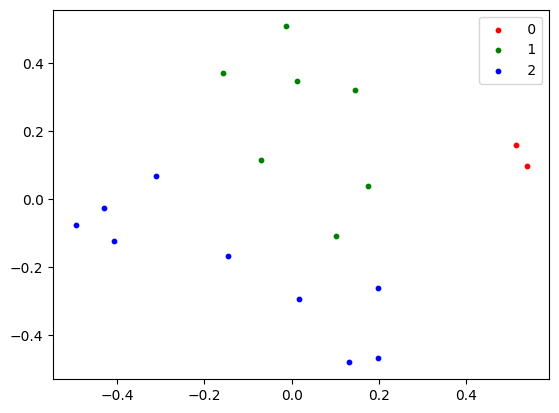

In [79]:
colors = ['red', 'green', 'blue'] 
cluster = [0, 1, 2] 
for i in range(3): 
    plt.scatter(reduced_data[kmeans.labels_ == i, 0], 
                reduced_data[kmeans.labels_ == i, 1],
                s=10, color=colors[i],  
                label=f' {cluster[i]}') 
plt.legend() 
plt.show()

#### Doc2Vec

In [68]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [69]:
tokenized_paragraphs = [word_tokenize(p) for p in paragraphs]

In [70]:
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_paragraphs)]
tagged_data[0]

TaggedDocument(words=['The', 'study', 'of', 'systems', 'that', 'behave', 'intelligently', ',', 'artificial', 'intelligence', 'includes', 'several', 'key', 'areas', 'where', 'our', 'faculty', 'are', 'recognized', 'leaders', ':', 'computer', 'vision', ',', 'machine', 'listening', ',', 'natural', 'language', 'processing', ',', 'machine', 'learning', 'and', 'robotics', '.'], tags=['0'])

In [71]:
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [72]:
similarity_threshold = 0.7
clusters = {}
for i, passage in enumerate(paragraphs):
    similar_passages = model.dv.most_similar(str(i), topn=len(paragraphs))
    group = [int(p[0]) for p in similar_passages if p[1] >= similarity_threshold]
    clusters[i] = group

In [73]:
for group, members in clusters.items():
    print(f"Group {group + 1}:")
    for member in members:
        print(paragraphs[member])
    print()

Group 1:
Applications are accepted on a rolling basis, however, students are encouraged to apply as soon as possible.
100 Materials Science and Engineering Building, 1304 W. Green St. Urbana, IL 61801
Learn more about program dates, format, and funding for the summer research program.
The SRP will take place in a hybrid format with both in-person and online offerings.
Undergraduates at Illinois Computer Science are an important part of our world-renowned research. From summer programs to paid research positions with faculty, there are multiple ways for our students to contribute to high impact research early in their careers.
The AI group at Illinois is strong, diverse, and growing. It combines expertise in core strengths with promising new research directions.
Funding, including rate of pay and number of hours of work, is determined on an individual basis between the participant and faculty research mentor after the student has been accepted to the program and matched with a faculty m